$$J=\mu-\frac{p_{||}}{k_i(t)}=\frac{m_e v_v^2}{2\omega_{ce}}-\frac{p_{||}}{k_i(t)}$$
$$v_v=\sqrt{\frac{2\omega_{ce}}{m_e}(J+\frac{p_{||}}{k_i(t)})}$$
$$\Omega=\frac{p_{||}}{k_i(t)}-\Pi_i$$
$$v_v=\sqrt{\frac{2\omega_{ce}}{m_e}(J+\Omega+\Pi_i)}$$
$$I=\iint v_v f_{trap} e^{i\xi}d\Omega d\xi$$
$$\chi=\frac{\omega_{pe}^2}{\omega(\Omega_e-\omega)}$$
$$I_{cold}=-\frac{i\omega}{4\pi}\chi E$$

In [1]:
import numpy as np
import os
import os.path as osp
import pickle
import matplotlib.pyplot as plt

In [2]:
dist=np.load("/home/wzy/segment-anything/data/data1/newd.npy")
print(dist.shape)
feq_lis=np.load("/home/wzy/segment-anything/data/data1/feq.npy")
feq_lis=np.transpose(feq_lis)
print(feq_lis.shape)
wb_lis=np.load("/home/wzy/segment-anything/data/data1/wb2.npy")
print(wb_lis.shape)
k_lis=np.load("/home/wzy/segment-anything/data/data1/kmode.npy")
print("k_lis",k_lis.shape)
wb_cplx_lis=np.load("/home/wzy/segment-anything/data/data1/wb2_cplx.npy")
print(wb_cplx_lis.shape)
chor_lis=np.load("/home/wzy/segment-anything/data/data1/chor.npy")
print(chor_lis.shape)
alpha_lis=np.load("/home/wzy/segment-anything/data/data1/alpha.npy")
print(alpha_lis.shape)
gyro_lis=np.load("/home/wzy/segment-anything/data/data1/gyro.npy")
print(gyro_lis.shape)
Jact_lis=np.load("/home/wzy/segment-anything/data/data1/Jact.npy")
print(Jact_lis.shape)
vr_lis=np.load("/home/wzy/segment-anything/data/data1/vr.npy")
print(Jact_lis.shape)
sour_lis=np.load("/home/wzy/segment-anything/data/data1/sour.npy")
print(sour_lis.shape)
zpos_lis=np.load("/home/wzy/segment-anything/data/data1/zpos.npy")
print(zpos_lis.shape)

(10, 1001, 31, 401)
(1001, 401)
(998, 1000)
k_lis (1001,)
(1000, 1001)
(1000, 1002, 2)
(1000, 1000)
(1001,)
(1001,)
(1001,)
(1000, 1002, 2)
(1001,)


In [3]:
chor_lis_=chor_lis[:,:,0]+1j*chor_lis[:,:,1]
theta_lis=np.angle(chor_lis_)
delta_w_lis=(theta_lis[1:,:]-theta_lis[:-1,:])[:,:-2]/48.9
delta_k_lis=((theta_lis[:,1:]-theta_lis[:,:-1])[:,:-1]/(zpos_lis[1:]-zpos_lis[:-1])[None,:])[:-1,:]
vr_lis_=vr_lis[None,:-1]
k_lis_=k_lis[None,:-1]

In [4]:
print(delta_w_lis.shape)
print(delta_k_lis.shape)
print(vr_lis_.shape)
print(k_lis_.shape)

(999, 1000)
(999, 1000)
(1, 1000)
(1, 1000)


In [5]:
Omega_lis=(delta_w_lis-vr_lis_*delta_k_lis)/(k_lis_**2)

Text(0, 0.5, '$v_{\\perp}$')

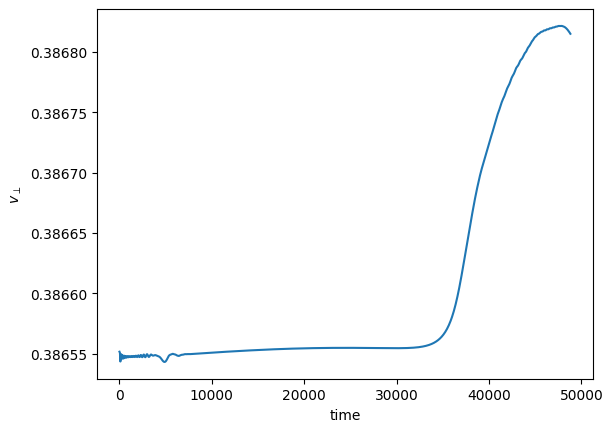

In [16]:
s=800
J=Jact_lis[s]
Pi=vr_lis[s]/k_lis[s]
omega_ce=gyro_lis[s]
Omega=Omega_lis[:,s]
v_perp=np.sqrt(2*omega_ce*(J+Omega+Pi))
time_lis=[]
vperp_=[]
for id,i in enumerate(v_perp):
    if abs(i)>0.4 or i<0.35:
        continue
    time_lis.append(id*48.9)
    vperp_.append(i)
plt.plot(time_lis,vperp_)
# plt.ylim(0,1e-3)
plt.xlabel("time")
plt.ylabel(r"$v_{\perp}$")

In [3]:
wl=0.30328825168137874/5
vperp0=0.3
nh=0.002
gyro0=0.2
def f_Pi(vr, kmode):
    return vr/kmode
def S_inte(f, mask:np.ndarray, x_range=[0,2*np.pi],y_range=[-0.1,0.1]):
    y_len, x_len = mask.shape
    x_lis=np.linspace(x_range[0],x_range[1],x_len)
    y_lis=np.linspace(y_range[0],y_range[1],y_len)
    dj=f(x_lis,y_lis[:,None])*mask
    f=np.trapz(dj,x_lis)
    fg = np.trapz(f,y_lis)
    return fg

def current(f_trap,mask_origin,J,Pi,omega_ce,ks,x_range=[0,2*np.pi]):
    f_trap=np.transpose(f_trap)
    mask_origin=np.transpose(mask_origin)

    coef=ks*nh*vperp0**2/gyro0*np.exp(1)
    def v_ver(Omega):
        return np.sqrt(2*omega_ce*(J+Omega+Pi))
    def f(x,y):
        return v_ver(y)*f_trap*np.exp(1j*x)
    return -coef*S_inte(f,mask_origin,x_range=x_range)
def current2(gyro,A):
    A=A[0]+1j*A[1]
    xi=1/(wl*(gyro-wl))
    j=-1j*(wl/4*np.pi)*xi*wl*A
    return j


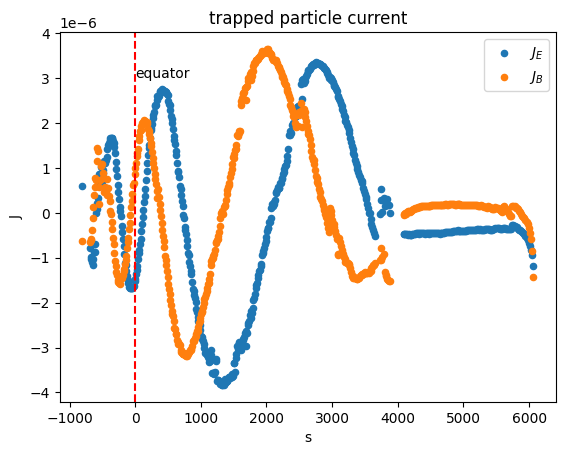

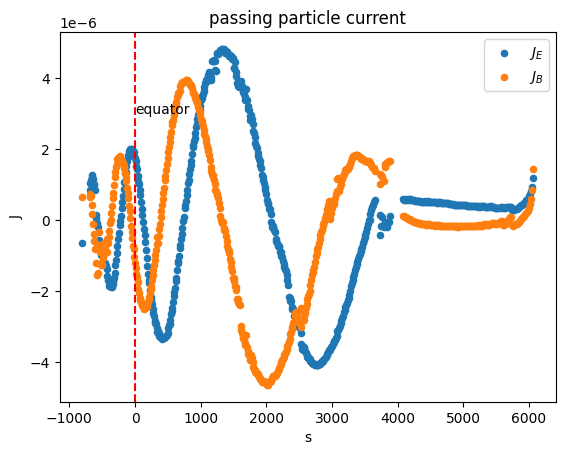

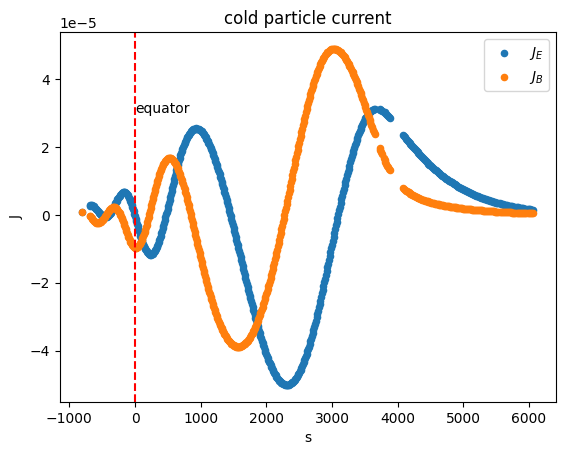

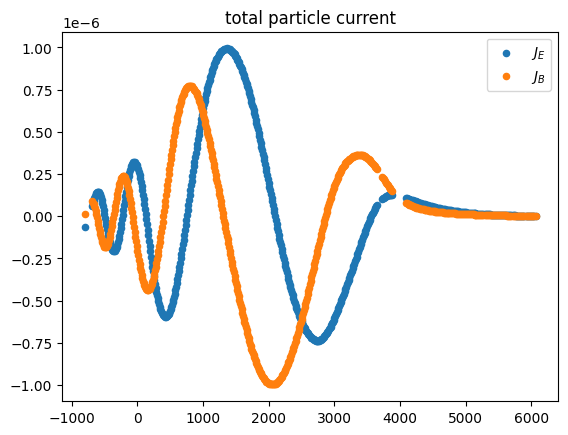

In [16]:
time=7
s=600
trapped_current_lis=[]
passing_current_lis=[]
cold_current_lis=[]
all_current_lis=[]
for s in range(0,1000):
    res_dir="/home/wzy/segment-anything/outputs/mask_res"
    f_trap=dist[time,s,:,:]
    f_trap_2cir=np.concatenate((f_trap,f_trap),axis=0)
    file_path=osp.join(res_dir,f"{time}_{s}_True.pkl")
    if osp.exists(file_path):
        with open(file_path,"rb") as fp:
            mask,is_construct=pickle.load(fp)
            # print(1-mask+mask)
            # break
        real_time=time*100+99
        J=Jact_lis[s]
        Pi=f_Pi(vr_lis[s],k_lis[s])
        omega_ce=gyro_lis[s]
        ks=k_lis[s]
        trapped_current=current(f_trap_2cir,mask,J,Pi,omega_ce,ks,x_range=[0,4*np.pi])
        trapped_current_lis.append(trapped_current)
        all_current=current(f_trap_2cir,1-mask+mask,J,Pi,omega_ce,ks,x_range=[0,4*np.pi])
        all_current_lis.append(all_current/2)
        passing_current_lis.append(all_current/2-trapped_current)
        cold_current=current2(gyro_lis[s],chor_lis[real_time][s])
        cold_current_lis.append(cold_current)
    else:
        passing_current_lis.append(None)
        trapped_current_lis.append(None)
        cold_current_lis.append(None)
        all_current_lis.append(None)
def scatter(x_lis, y_lis, s=20):
    x=[]
    y=[]
    for i in range(len(x_lis)):
        if y_lis[i] is not None:
            x.append(x_lis[i])
            y.append(y_lis[i])
    # print(y)
    plt.scatter(x,y,s=s)

space_lis=zpos_lis[:1000]

plt.figure()
scatter(space_lis,[np.real(i) if i is not None else None for i in trapped_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None for i in trapped_current_lis])
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, 3e-6, 'equator', ha='left')
plt.title(f"time={time} trapped")
plt.xlabel("s")
plt.ylabel("J")
plt.legend([r"$J_E$",r"$J_B$"])
plt.title("trapped particle current")
plt.show()
plt.figure()
scatter(space_lis,[np.real(i) if i!=None else None for i in passing_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None for i in passing_current_lis])
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, 3e-6, 'equator', ha='left')
plt.title(f"time={time} passing")
plt.title("passing particle current")
plt.xlabel("s")
plt.ylabel("J")
plt.legend([r"$J_E$",r"$J_B$"])
plt.show()
plt.figure()
scatter(space_lis,[np.real(i) if i!=None else None for i in cold_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None  for i in cold_current_lis])
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, 3e-5, 'equator', ha='left')
plt.title(f"time={time} cold")
plt.legend([r"$J_E$",r"$J_B$"])
plt.title("cold particle current")
plt.xlabel("s")
plt.ylabel("J")
plt.show()
current_lis=[]
for i in range(len(passing_current_lis)):
    if passing_current_lis[i] is not None:
        current_lis.append(passing_current_lis[i]+trapped_current_lis[i])
    else:
        current_lis.append(None)
plt.figure()
scatter(space_lis,[np.real(i) if i is not None else None for i in all_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
plt.title(f"time={time}")
plt.legend([r"$J_E$",r"$J_B$"])
plt.title("total particle current")
plt.show()


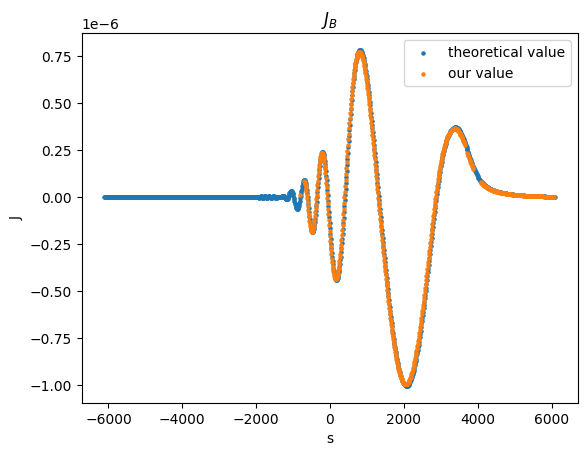

In [22]:
sour=sour_lis[700+99,:,:]
plt.figure()
scatter(space_lis,sour[:,1],s=5)
# scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
scatter(space_lis,[np.imag(i) if i is not None else None for i in all_current_lis],s=5)
plt.title(f"time={time}")
plt.xlabel("s")
plt.ylabel("J")
plt.legend([r"theoretical value",r"our value"])
plt.title(r"$J_B$")
plt.show()


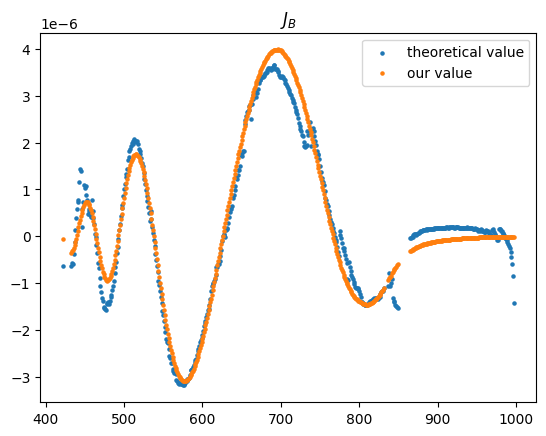

In [6]:
sour=sour_lis[700+99,:,:]
plt.figure()
scatter(space_lis,[np.imag(i) if i is not None else None for i in trapped_current_lis],s=5)
# scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
scatter(space_lis,[-4*np.imag(i) if i is not None else None for i in all_current_lis],s=5)
plt.title(f"time={time}")
plt.legend([r"theoretical value",r"our value"])
plt.title(r"$J_B$")
plt.show()

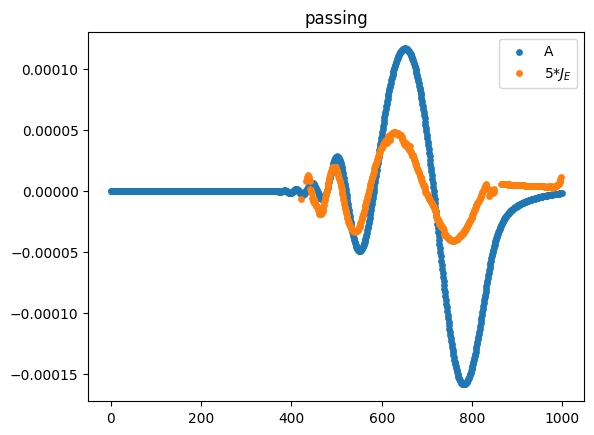

In [7]:

plt.figure()
scatter(space_lis,[np.real(i) if i is not None else None for i in chor_lis[799,:,0]],s=15)
# scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
scatter(space_lis,[10*np.real(i) if i is not None else None for i in passing_current_lis],s=15)
plt.title(f"time={time}")
plt.legend([r"A",r"5*$J_E$"])
plt.title(r"passing")
plt.show()

In [8]:
id1=np.argmax(chor_lis[799,:,0])
passing=[5*np.real(i) if i is not None else None for i in passing_current_lis]
id2=passing.index(max([5*np.real(i) if i is not None else 0 for i in passing_current_lis]))
id2-id1

-21

In [9]:
def find_local_maxima(data, window_size):
    local_maxima = []
    n = len(data)
    
    if n <= window_size:
        return local_maxima
    
    for i in range(window_size, n - window_size):
        if data[i] > max(data[i-window_size:i]) and data[i] > max(data[i+1:i+window_size+1]):
            local_maxima.append((i, data[i]))
    
    return sorted(local_maxima,key=lambda x:x[1])

local_maxima = find_local_maxima(chor_lis[799,:,0], 10)
print("所有的局部极大值：", local_maxima)


所有的局部极大值： [(252, 3.791741391026229e-09), (200, 6.198344084680397e-09), (338, 6.871315151123885e-08), (350, 9.335337887990805e-08), (364, 1.172795253891367e-07), (385, 4.2202671349118135e-07), (410, 1.4105829753240952e-06), (445, 6.752509882336831e-06), (501, 2.8343218503956468e-05), (651, 0.00011701688147924366)]


In [10]:
local_maxima

[(252, 3.791741391026229e-09),
 (200, 6.198344084680397e-09),
 (338, 6.871315151123885e-08),
 (350, 9.335337887990805e-08),
 (364, 1.172795253891367e-07),
 (385, 4.2202671349118135e-07),
 (410, 1.4105829753240952e-06),
 (445, 6.752509882336831e-06),
 (501, 2.8343218503956468e-05),
 (651, 0.00011701688147924366)]

In [11]:
651-501

150

In [12]:
21/150

0.14